In [33]:
#ZAD1
import os
import numpy as np
import pandas as pd
import spacy
import re
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

sia = SentimentIntensityAnalyzer()
nlp = spacy.load('en_core_web_md')


In [5]:
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\KamilSarzyniak\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KamilSarzyniak\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\KamilSarzyniak\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [173]:
data = pd.read_csv('sample.csv')

In [174]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text

In [175]:
data['cleaned_text'] = data['comment_text'].apply(preprocess_text)

In [176]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000, ngram_range=(1, 2))  # 1-2 grams
tfidf_matrix = vectorizer.fit_transform(data['cleaned_text'])

In [199]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(tfidf_matrix)

KMeans(n_clusters=3)

In [200]:
data['cluster'] = kmeans.labels_

In [201]:
sarcasm_markers = ['yeah right', 'sure', 'totally', 'not really', 'of course', 'lol']

In [202]:
def detect_sarcasm(text):
    for marker in sarcasm_markers:
        if marker in text:
            return True
    return False

In [203]:
data['sarcasm'] = data['cleaned_text'].apply(detect_sarcasm)

In [204]:
irony_markers = [
    'oh really', 'how surprising', 'of course not', 'what a surprise', 
    'unexpected', 'how ironic', 'as if', 'so unexpected', 'right, because that works'
]

In [205]:
def detect_irony(text):
    for marker in irony_markers:
        if marker in text:
            return True
        
    sentiment = sia.polarity_scores(text)
    if sentiment['pos'] > 0.5 and sentiment['neg'] > 0.5:
        return True
    return False

In [206]:
data['irony'] = data['cleaned_text'].apply(detect_irony)

In [207]:
sarcasm_count = data['sarcasm'].sum()
irony_count = data['irony'].sum()
non_sarcastic_or_ironic_count = len(data) - sarcasm_count - irony_count

In [208]:
labels = ['Non-Sarcastic/Non-Ironic', 'Sarcastic', 'Ironic']
counts = [non_sarcastic_or_ironic_count, sarcasm_count, irony_count]

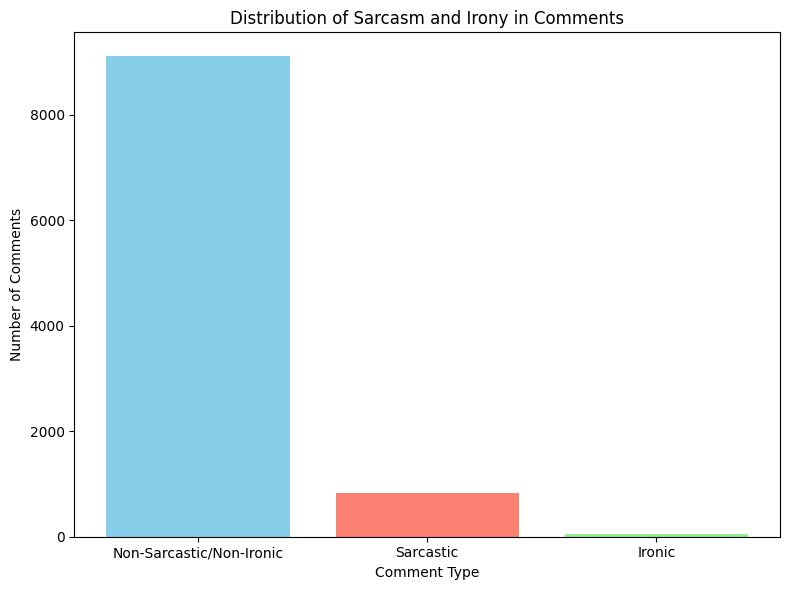

In [209]:
plt.figure(figsize=(8, 6))
plt.bar(labels, counts, color=['skyblue', 'salmon', 'lightgreen'])
plt.title('Distribution of Sarcasm and Irony in Comments')
plt.xlabel('Comment Type')
plt.ylabel('Number of Comments')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [9]:
#ZAD2
with open('anna_karenina.txt', 'r', encoding='utf-8') as f:
    anna_text = f.read()

with open('jane_eyre.txt', 'r', encoding='utf-8') as f:
    jane_text = f.read()

dialogue_pattern = r'“([^”]+)”|"([^"]+)"'

anna_dialogues = [match[0] or match[1] for match in re.findall(dialogue_pattern, anna_text)]
jane_dialogues = [match[0] or match[1] for match in re.findall(dialogue_pattern, jane_text)]

with open('anna_dialogues.txt', 'w', encoding='utf-8') as output_file:
        for dialogue in anna_dialogues:
            output_file.write(dialogue + '\n')

with open('jane_dialogues.txt', 'w', encoding='utf-8') as output_file:
        for dialogue in jane_dialogues:
            output_file.write(dialogue + '\n')

In [11]:
#ZAD2
anna_karenina = 'anna_karenina.txt'
jane_eyre = 'jane_eyre.txt'

def extract_dialogues(file_name):
    with open(file_name, 'r', encoding='utf-8') as f:
        text = f.read()

    dialogue_pattern = r'“([^”]+)”|"([^"]+)"'

    dialogues = [match[0] or match[1] for match in re.findall(dialogue_pattern, text)]

    with open(f'{file_name}'+'.dialogues', 'w', encoding='utf-8') as output_file:
        for dialogue in dialogues:
            output_file.write(dialogue + '\n')


extract_dialogues(anna_karenina)
extract_dialogues(jane_eyre)


In [21]:
names = ['Anna', 'Alexandrovna', 'Jane', 'Edward']
anna_karenina = 'anna_karenina.txt.dialogues'
jane_eyre = 'jane_eyre.txt.dialogues'

def recognize_the_characters(file_name):
    with open(file_name, 'r', encoding='utf-8') as file:
        text = file.read()

    name_pattern = r'\b(' + '|'.join(names) + r')(?:\W.*?)(?:\.|$)'

    person_sentences = {name: [] for name in names}

    for match in re.finditer(name_pattern, text):
        sentence = text[max(0, match.start()-100):min(len(text), match.end()+100)]
        for name in names:
            if re.search(rf'\b{name}\b', sentence):
                person_sentences[name].append(sentence.strip())

    with open(f'{file_name}'+'-characters', 'w', encoding='utf-8') as file:
        for name, sentences in person_sentences.items():
            file.write(f"Text related to {name}:\n")
            for s in sentences:
                file.write(f"- {s}\n")

recognize_the_characters(anna_karenina)
recognize_the_characters(jane_eyre)


In [27]:
character_vectors = {}

In [ ]:
anna_karenina = 'anna_karenina.txt.dialogues-characters'
jane_eyre = 'jane_eyre.txt.dialogues-characters'

def text_into_vectors(file_name):
    character_name = os.path.splitext(os.path.basename(file_name))[0]

    with open(file_name, 'r', encoding='utf-8') as file:
        text = file.read()

    doc = nlp(text)
    sentences = list(doc.sents)
    character_vectors[character_name] = [sent.vector for sent in sentences]   

text_into_vectors(anna_karenina)
text_into_vectors(jane_eyre)

In [29]:
characters = list(character_vectors.keys())
vectors = np.array(list(character_vectors.values()))
similarities = cosine_similarity(vectors)

In [31]:
print("Semantic similarities between characters:")
for i, char1 in enumerate(characters):
    for j, char2 in enumerate(characters):
        if i < j:
            print(f"Similarity between {char1} and {char2}: {similarities[i][j]:.2f}")

Semantic similarities between characters:
Similarity between anna_karenina.txt and jane_eyre.txt: 1.00


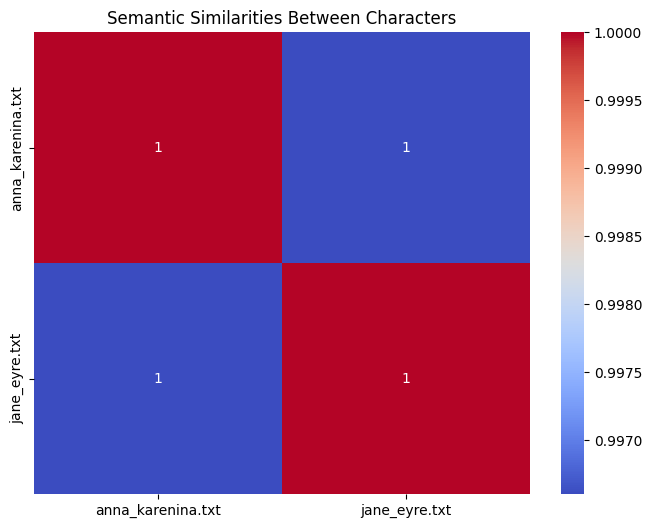

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(similarities, annot=True, xticklabels=characters, yticklabels=characters, cmap='coolwarm', cbar=True)
plt.title("Semantic Similarities Between Characters")
plt.show()